In [1]:
import numpy as np
import gym
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from gym import wrappers
from datetime import datetime


env = gym.make('MountainCar-v0')

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
# copied from lazyprogrammer
def plot_cost_to_go(env, estimator, num_tiles=20):
  x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
  y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
  X, Y = np.meshgrid(x, y)
  # both X and Y will be of shape (num_tiles, num_tiles)
  Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
  # Z will also be of shape (num_tiles, num_tiles)

  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(X, Y, Z,
    rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_zlabel('Cost-To-Go == -V(s)')
  ax.set_title("Cost-To-Go Function")
  fig.colorbar(surf)
  plt.show()


def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()



In [57]:
#copied from lazyprogrammer
from sklearn.kernel_approximation import RBFSampler
class FeatureTransformer:
  def __init__(self, env, n_components=500):
    observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    scaler = StandardScaler()
    scaler.fit(observation_examples)

    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])
    example_features = featurizer.fit_transform(scaler.transform(observation_examples))

    self.dimensions = example_features.shape[1]
    self.scaler = scaler
    self.featurizer = featurizer

  def transform(self, observation):
    observations = [observation]
#     print("observations:", observations, observations.shape)
    scaled = self.scaler.transform(observations)
    # assert(len(scaled.shape) == 2)
    return self.featurizer.transform(scaled)

feature_transformer = FeatureTransformer(env)

In [56]:
np.array([env.observation_space.sample()]).shape
# feature_transformer.transform(np.array([env.observation_space.sample()]))

(1, 2)

In [58]:
feature_transformer.transform(env.observation_space.sample())

array([[ 0.00940201, -0.03577713,  0.05891342, ..., -0.02495072,
         0.06321942, -0.06254431]])

In [31]:
np.random.randint

In [ ]:
np.array([0,1]).reshape

In [76]:
# Holds one SGDRegressor for each action
class Model:
  def __init__(self, env, feature_transformer, learning_rate):
    self.env = env
    self.feature_transformer = feature_transformer
    self.learning_rate = learning_rate
    self.regressors = [SGDRegressor(learning_rate=learning_rate) for _ in range(3)]
#     observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
#     transformed_examples = [feature_transformer.transform(o) for o in observation_examples]
    for regressor in self.regressors:
        s = feature_transformer.transform(env.reset())
        regressor.partial_fit(s, [0])

  def estimate_state_value(self, state):
    return np.max(self.predict(state))    
    
  def predict(self, state):
    transformed_state = self.feature_transformer.transform(state)
    return [r.predict(transformed_state) for r in self.regressors]

  def update(self, state, a, G):
    transformed_state = self.feature_transformer.transform(state)
    self.regressors[a].partial_fit(transformed_state, [G])

  def sample_action(self, s, eps):
    # eps = 0
    # Technically, we don't need to do epsilon-greedy
    # because SGDRegressor predicts 0 for all states
    # until they are updated. This works as the
    # "Optimistic Initial Values" method, since all
    # the rewards for Mountain Car are -1.
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))

lr = 'invscaling'  #0.001
model = Model(env, feature_transformer, lr)

In [77]:
# returns a list of states_and_rewards, and the total reward
def play_all(model, eps, gamma, n=5, n_games=1):
    # Insert code here
    total_rewards = []
    
    for i in range(n_games):
        total_reward = play_one(eps, gamma, env, model)    
        print('total_reward',total_reward)
        total_rewards += [total_reward]
        
    # after code plot some stuff:
    plt.plot(total_rewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(np.array(total_rewards))

    # plot the optimal state-value function
    plot_cost_to_go(env, model)

def play_one(eps, gamma, env, model):
    state = env.reset()
    history = []  #state, reward, is_done, info
    is_done = False
    
    total_reward = 0
    while not is_done:        
        action = model.sample_action(state, eps)
#         print(action)
        history += [env.step(action)]
        state, reward, is_done, _info = history[-1]
        total_reward += reward
        
        model.update(state, action, reward + gamma*model.estimate_state_value(state))
    return total_reward


total_reward -200.0
total_reward -200.0
total_reward -200.0
total_reward -200.0
total_reward -200.0


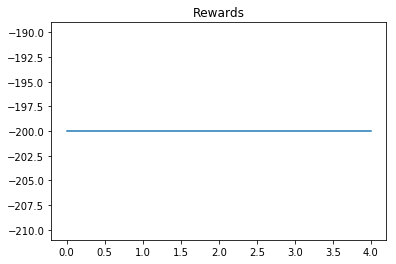

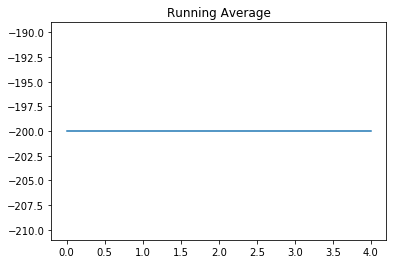

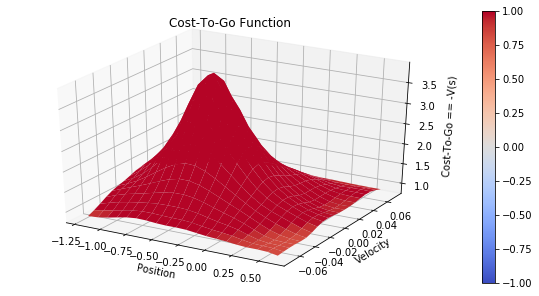

In [78]:
play_all(model, 0.1, 0.9, n_games=5)

In [13]:
env.step?